# Audio Noise Separation

Proposed Algorithm :
1. Load Audio
2. Convert it from time domain data to frequency domain data using FFT(Fast Fourier Transformation)
3. Perform Calculations(Separate noise from audio)
4. Apply Inverse Fourier Transformation on extracted audios
5. Export Audios


Resources : 
- [Understanding Audio data](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)

In [84]:
import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import scipy
import numpy as np
import soundfile as sf

## Step 1 : Load Audio

In [85]:
# loading audio
def load_audio(filepath):
    samples, sampling_rate = librosa.load(filepath, sr = None, mono = True, offset = 0.0, duration = None)
    return samples, sampling_rate
    
file_path = "./data/sample1/source.wav"
samples, sampling_rate = load_audio(file_path)
len(samples), sampling_rate

/home/debashish/miniconda3/envs/mini-project/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(147456, 44100)

In [86]:
# duration
duration_of_sound = len(samples) / sampling_rate
print("Duration of audio :", duration_of_sound, "seconds")

Duration of audio : 3.3436734693877552 seconds


In [87]:
Audio(file_path)

### Time domain representation

In [88]:
 def plot_waveshow_td_representation(audio, sampling_rate):
    plt.figure(figsize=(15,7))
    display.waveshow(y = audio, sr = sampling_rate)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Amplitude")
    return plt.show()

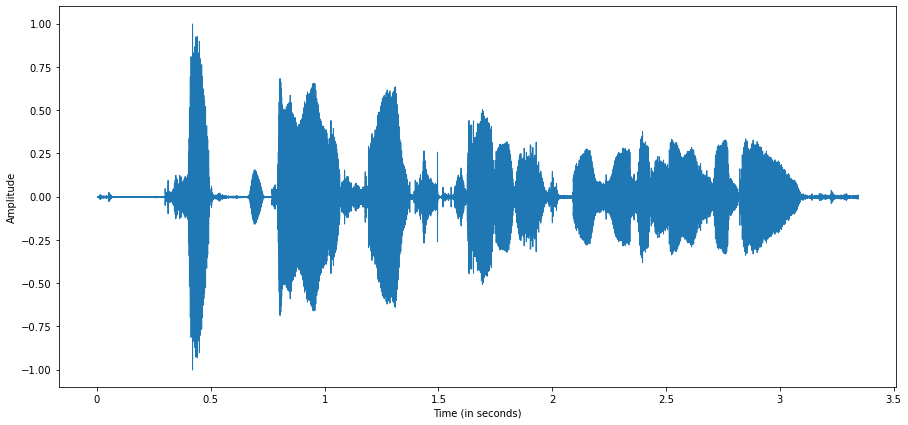

In [89]:
plot_waveshow_td_representation(samples, sampling_rate)

## Step 2 : Apply Fourier Transform

### Frequency domain representation

In [90]:
def perform_fft(audio, sampling_rate):
    n = len(audio)
    T = 1/sampling_rate
    frequency_data = scipy.fft.fft(audio)
    magnitude = np.linspace(0.0, 1.0/(2.0*T), n//2)
    return frequency_data, magnitude

In [91]:
def plot_fd_representation(frequency_data, magnitude):
    plt.rcParams["figure.figsize"] = [15, 7]
    n = len(frequency_data)
    fig, ax = plt.subplots()
    ax.plot(magnitude, 2.0/n * np.abs(frequency_data[:n//2]))
    plt.grid()
    plt.xlabel("Frequency ->")
    plt.ylabel("Magnitude")
    return plt.show()

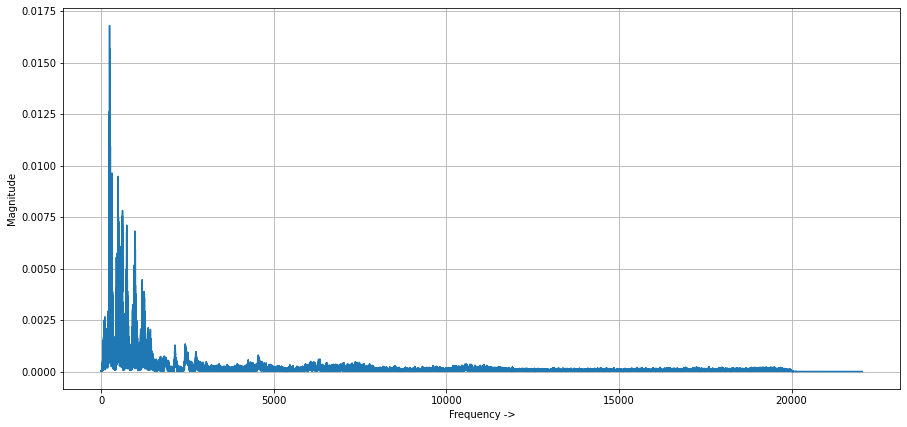

In [92]:
frequency_data, magnitude = perform_fft(samples, sampling_rate)
plot_fd_representation(frequency_data, magnitude)

### Spectrogram

In [93]:
def spectrogram(samples, sample_rate, stride_ms = 10.0,window_ms = 20.0, max_freq = None, eps = 1e-14):
    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [94]:
def plot_specgram(specgram, audio_len, sampling_rate):
    plt.imshow(np.transpose(specgram), extent=[0,audio_len,0,sampling_rate//2], vmin=-30, vmax=0, cmap='magma', origin='lower', aspect='auto')
    # extent :
    #   x-axis limits : 0 to audio length in seconds (time)
    #   y-axis limits : 0 to sampling rate (frequency)
    # vmin, vmax : -30db to 0db
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    return plt.show()

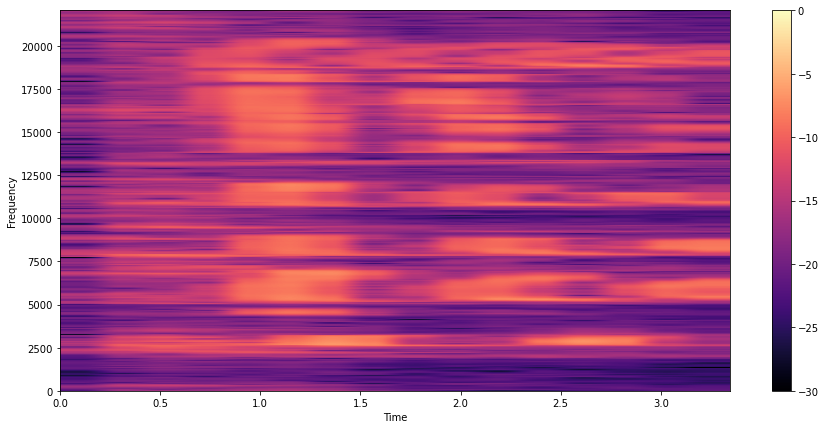

In [95]:
specgram_data = spectrogram(samples, sampling_rate, max_freq=max(frequency_data))
plot_specgram(specgram_data, duration_of_sound, sampling_rate) 

## Step 3 : Perform Calculations

In [96]:
print("Frequency data :",frequency_data)
print(frequency_data.shape)
print("Spectrogram data :",specgram_data)
print(specgram_data.shape)

Frequency data : [ 1.8893738 -0.j         -2.4866521 -1.6020343j  -0.19551134-0.42524254j
 ...  2.0382354 +0.18899524j -0.19551134+0.42524254j
 -2.4866521 +1.6020343j ]
(147456,)
Spectrogram data : [[-22.53331853 -20.89959028 -18.71756429 ... -17.73093987 -16.40215602
  -16.6121496 ]
 [-16.88616962 -17.00111503 -19.8234146  ... -15.69021778 -15.79817552
  -17.5283312 ]
 [-16.86588597 -19.64717427 -17.59868196 ... -17.64442592 -17.45033972
  -16.61651471]
 ...
 [-23.21268033 -22.01540284 -20.68830769 ... -20.41083701 -19.83378848
  -22.46042143]
 [-22.06260438 -21.28005043 -21.36035153 ... -19.91193584 -23.92570172
  -21.66679553]
 [-21.24856107 -21.38327772 -21.7526327  ... -21.29824301 -21.70466292
  -22.78583242]]
(16, 333)


## Step 4 : Perform Inverse Fourier Transform

### Inverse fourier transform

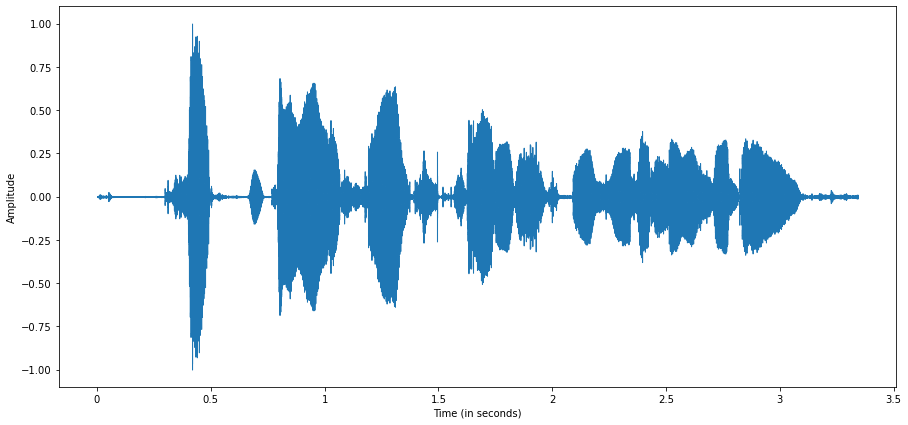

In [97]:
inverse_fft_result = scipy.fftpack.ifft(frequency_data).real
plot_waveshow_td_representation(inverse_fft_result, sampling_rate)

## Step 5 : Extract Audio

In [98]:
def extract_audio(filename, audio, sampling_rate):
    sf.write(filename, audio, samplerate=sampling_rate)
    print("Extracted Successfully")

In [99]:
extract_audio('./output/output.wav', inverse_fft_result, sampling_rate)

Extracted Successfully
